In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/My Drive

/content/drive/My Drive


In [ ]:
from fastai import *
from fastai.vision import *
import random
random.seed(23)

In [ ]:
%cd rg-balance/

/content/drive/My Drive/rg-balance


In [ ]:
!ls

data-balanced.zip


In [ ]:
#!unzip data-balanced.zip


In [ ]:
!ls

data-balanced  data-balanced.zip


In [ ]:
path_img = Path('data-balanced')
bs = 32

data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1728 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FRII,FRII,FRII,FRII,FRII
Path: data-balanced;

Valid: LabelList (576 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FRII,FRII,FRII,FRII,FRII
Path: data-balanced;

Test: None

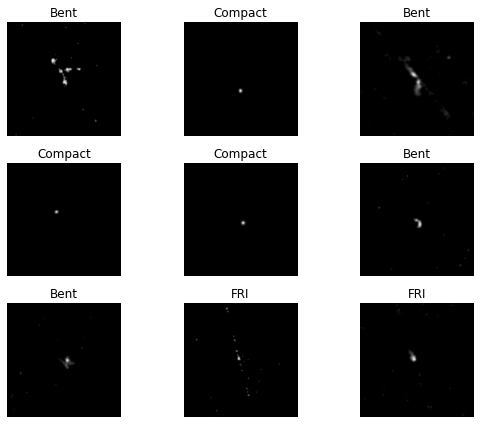

In [ ]:
data.show_batch(rows=3, figsize=(8,6))

In [ ]:
learn = cnn_learner(data, models.densenet161, metrics=accuracy)
learn.freeze()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


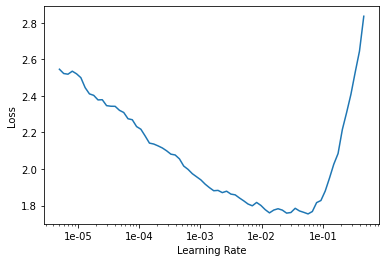

In [ ]:
learn.lr_find(start_lr=1e-6, end_lr=1e1, wd=5e-3)
learn.recorder.plot()#suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.369117,0.708919,0.741319,00:32


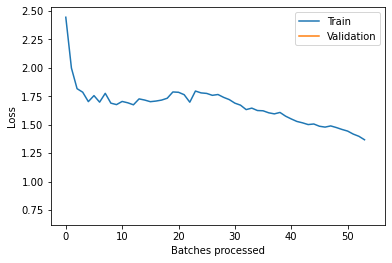

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(1e-4,3e-2))
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-05
Min loss divided by 10: 5.75E-05


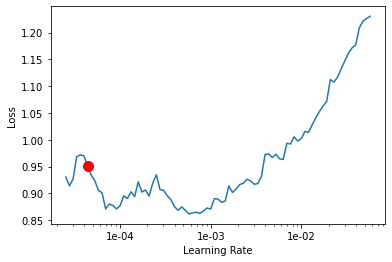

In [ ]:
learn.unfreeze()

# Find the learning rate for the fully trainable model
learn.lr_find(start_lr=slice(1e-6, 1e-5), end_lr=slice(1e-2, 1e-1), wd=1e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.162246,128.270721,0.250000,00:43
1,0.959017,1.227463,0.697917,00:45
2,0.738954,0.487722,0.861111,00:45


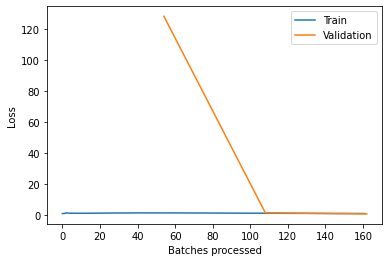

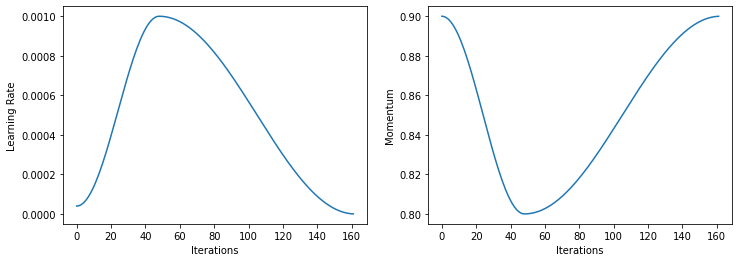

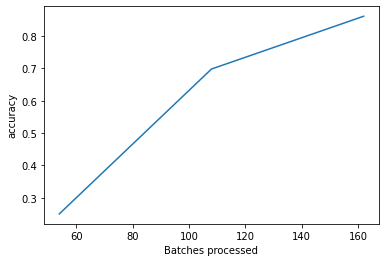

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(5e-4, 1e-3), wd=1e-3, moms=(0.9, 0.8))
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.248988,0.336289,0.876736,00:42
1,0.235539,0.938930,0.751736,00:43
2,0.309887,0.431070,0.873264,00:44
3,0.414392,1.051701,0.852431,00:44
4,0.543427,0.863995,0.649306,00:44
5,0.436097,1.979852,0.553819,00:44
6,0.491608,1.645676,0.505208,00:44
7,0.474700,0.985433,0.567708,00:44
8,0.411681,0.791012,0.675347,00:45
9,0.370427,0.718895,0.770833,00:45


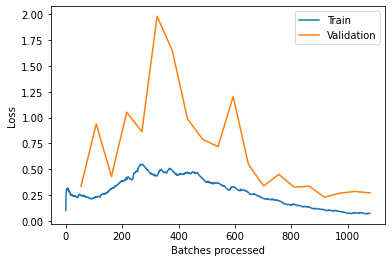

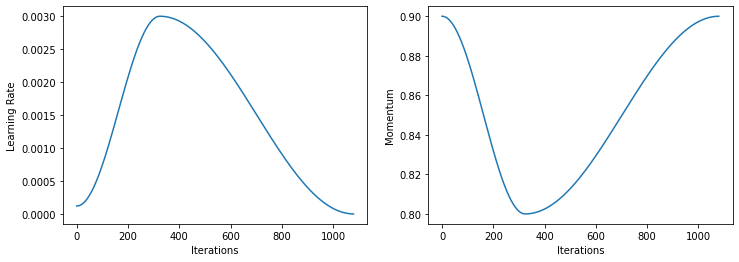

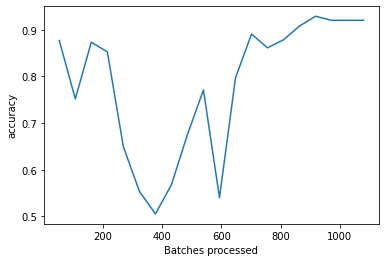

In [ ]:
learn.fit_one_cycle(cyc_len=20, wd=3e-2, moms=(0.9, 0.8))
learn.recorder.plot_losses()

learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()



trainloss = learn.sched.losses
valloss = learn.sched.val_losses
epochs = learn.sched.epochs
mini_batches= int(len(trainloss)/len(valloss))

epochs = [x / mini_batches for x in epochs]

plt.plot(epochs[1:],trainloss[mini_batches::mini_batches])
plt.plot(epochs[1:],valloss[1:])
plt.show()


In [ ]:
learn.save('rgbalance_model')

In [ ]:
learn.export('rgbalance_model.pkl')

In [ ]:
learn.load('rgbalance_model')
interp = ClassificationInterpretation.from_learner(learn)

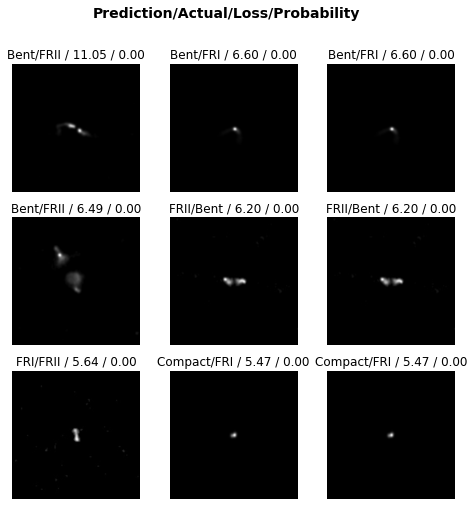

In [ ]:
interp.plot_top_losses(9, figsize=(8,8))


In [ ]:
losses, indexes = interp.top_losses(40)
top_loss_paths = data.valid_ds.x.items[indexes]
print(top_loss_paths)

[PosixPath('data-balanced/valid/FRII/J151108.76+180153.2.jpeg')
 PosixPath('data-balanced/valid/FRI/J140313.27+061008.2 (copy).jpeg')
 PosixPath('data-balanced/valid/FRI/J140313.27+061008.2.jpeg')
 PosixPath('data-balanced/valid/FRII/J144919.01+210548.0.jpg')
 PosixPath('data-balanced/valid/Bent/J080431.42+192212.9.jpg')
 PosixPath('data-balanced/valid/Bent/J080431.42+192212.9 (copy).jpg')
 PosixPath('data-balanced/valid/FRII/J153220.80+061153.5.jpeg')
 PosixPath('data-balanced/valid/FRI/J141104.33-030043.3.jpeg')
 PosixPath('data-balanced/valid/FRI/J141104.33-030043.3 (copy).jpeg')
 PosixPath('data-balanced/valid/FRII/J153004.69+290009.3.jpg')
 PosixPath('data-balanced/valid/FRII/J145752.77+111809.5.jpg')
 PosixPath('data-balanced/valid/FRI/J143521.30-024051.7 (copy).jpg')
 PosixPath('data-balanced/valid/FRI/J143521.30-024051.7.jpg')
 PosixPath('data-balanced/valid/FRI/J143848.86+004059.2 (copy).jpg')
 PosixPath('data-balanced/valid/FRI/J143848.86+004059.2.jpg')
 PosixPath('data-balan

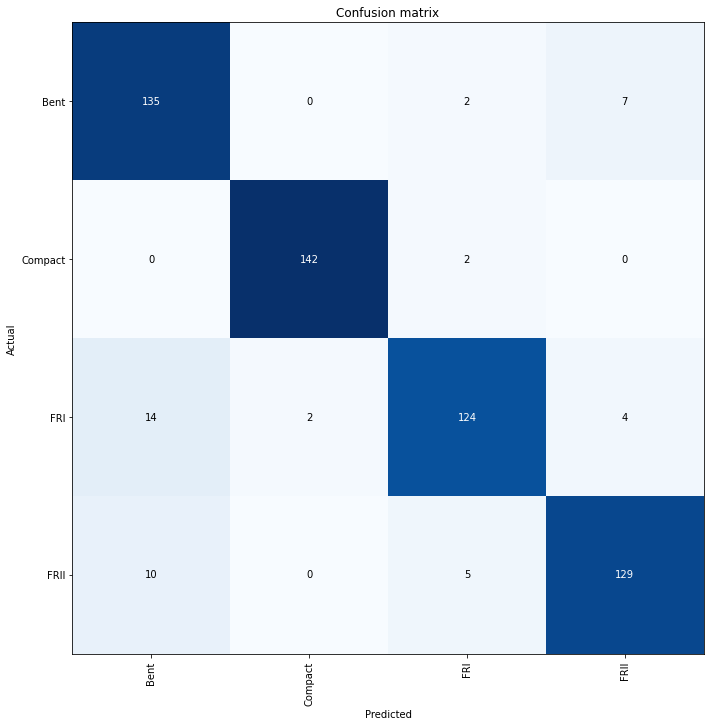

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
import glob

image_list = glob.glob('data-balanced/test/*/*')

Bent = 0
Pred_Bent = 0
Compact = 0
Pred_Compact = 0
FRI = 0
Pred_FRI=0
FRII = 0
Pred_FRII = 0 

for each in image_list:
    img = open_image(each)
    each = each.split('/')
    rg_class = each[2]
    pred_class, pred_idx, outputs = learn.predict(img)
    pred_class = str(pred_class)
         
    if rg_class == 'Bent':
        Bent += 1
        if pred_class == 'Bent':
            Pred_Bent += 1
    elif rg_class == 'Compact':
        Compact += 1
        if pred_class == 'Compact':
            Pred_Compact += 1
    elif rg_class == 'FRI':
        FRI += 1
        if pred_class == 'FRI':
            Pred_FRI += 1
    elif rg_class == 'FRII':
        FRII += 1
        if pred_class == 'FRII':
            Pred_FRII += 1
            
    
print('Bent TP: ' + str(Pred_Bent) + '/' + str(Bent))
print('Compact TP: ' + str(Pred_Compact) + '/' + str(Compact))
print('FRI TP: ' + str(Pred_FRI) + '/' + str(FRI) )
print('FRII TP: ' + str(Pred_FRII) + '/' + str(FRII) )

Bent TP: 91/103
Compact TP: 99/100
FRI TP: 93/100
FRII TP: 92/101


In [ ]:
path_img = Path('data-balanced')
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='test', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1728 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FRII,FRII,FRII,FRII,FRII
Path: data-balanced;

Valid: LabelList (404 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Compact,Compact,Compact,Compact,Compact
Path: data-balanced;

Test: None

In [ ]:
learn = cnn_learner(data, models.densenet161, metrics=[accuracy])

In [ ]:
learn = learn.load('rgbalance_model')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)


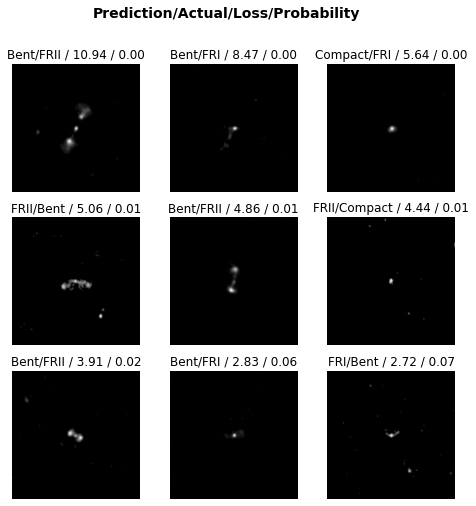

In [ ]:
interp.plot_top_losses(9, figsize=(8,8))


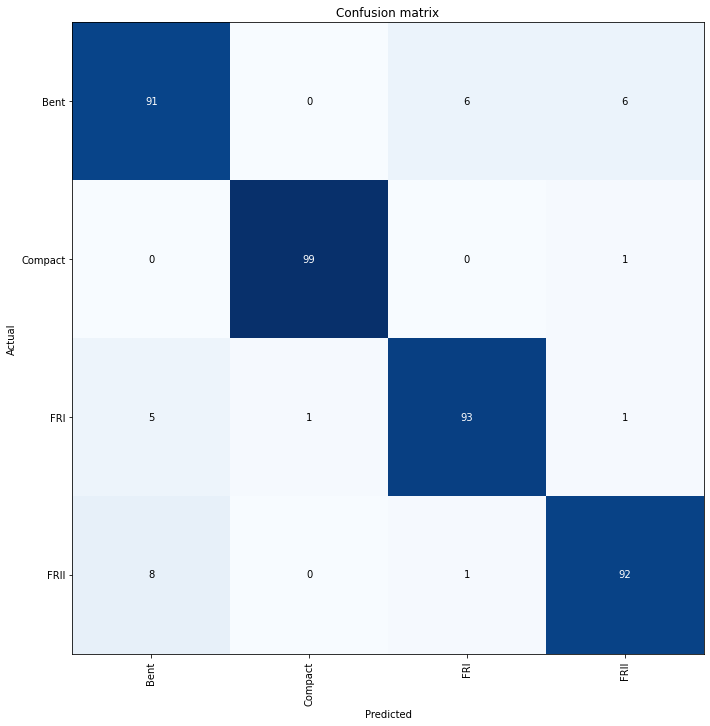

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))